# PREVENTING BANK CUSTOMER CHURN!

 ## 1. Introduction

We aim to accomplist the following for this study:

1. Identify and visualize which factors contribute to bank customer churn:
    
2. Build a prediction model that will perform the following:
    * Classify if a customer is going to churn or not
    * Based on model performance, choose a model that will predict the probability to the churn to make it easier for customer service to target low hanging fruits in their efforts to prevent churn

## 2. Data set review & preparation

In this section we will seek to explore the structure of our data: 
1. To understand the input space the data set
2. And to prepare the sets for exploratory and prediction tasks as described in section 1

In [1]:
## REQUIRED LIBRARIES
# For data wrangling 
import numpy as np
import pandas as pd

# For visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [2]:
# Read the data frame
df = pd.read_csv('Churn_Modelling.csv')
df.shape

(10000, 14)

The Df has 1000 rows with 14 attributes. We review this further to identify what attributes will be necessary and what data manipulation needs to be carried out before Exploratory analysis and prediction modelling

In [3]:
# Check columns list and missing values
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Well isn't that a rare find; no missing values! 

In [4]:
# Get unique count for each variable
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

From the above, we will not require the first 2 attributes as the are specific to a customer. It is borderline with the surname as this would result to profiling so we exclude this as well.

In [5]:
# Drop the columns as explained above
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

In [6]:
# Review the top rows of what is left of the data frame
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


From the above, a couple of question linger:
1. The data appears to be a snapshot as some point in time e.g. the balance is for a given date which leaves a lot of questions:
    * What date is it and of what relevance is this date
    * Would it be possible to obtain balances over a period of time as opposed to a single date.
2. There are customers who have exited but still have a balance in their account! What would this mean? Could they have exited from a product and not the bank?
3. What does being an active member mean and are there difference degrees to it? Could it be better to provide transaction count both in terms of credits and debits to the account instead?
4. A break down to the products bought into by a customer could provide more information topping listing of product count

For this exercise, we proceed to model without context even though typically having context and better understanding of the data extraction process would give better insight and possibly lead to better and contextual results of the modelling process

In [7]:
# Check variable data types
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

So we moslty have categorical variables and 5 continuous variables

## 3. Exploratory Data Analysis
Here our main interest is to get an understanding as to how the given attributes relate too the 'Exit' status.

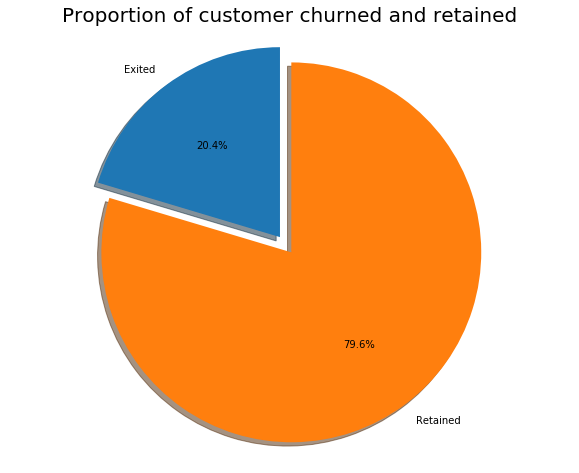

In [8]:
labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

So about 20% of the customers have churned. So the baseline model could be to predict that 20% of the customers will churn.
Given 20% is a small number,  we need to ensure that the chosen model does predict with great accuracy this 20% as it is of interest to the bank to identify and keep this bunch as opposed to accurately predicting the customers that are retained.

C:\Users\ab275\Anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


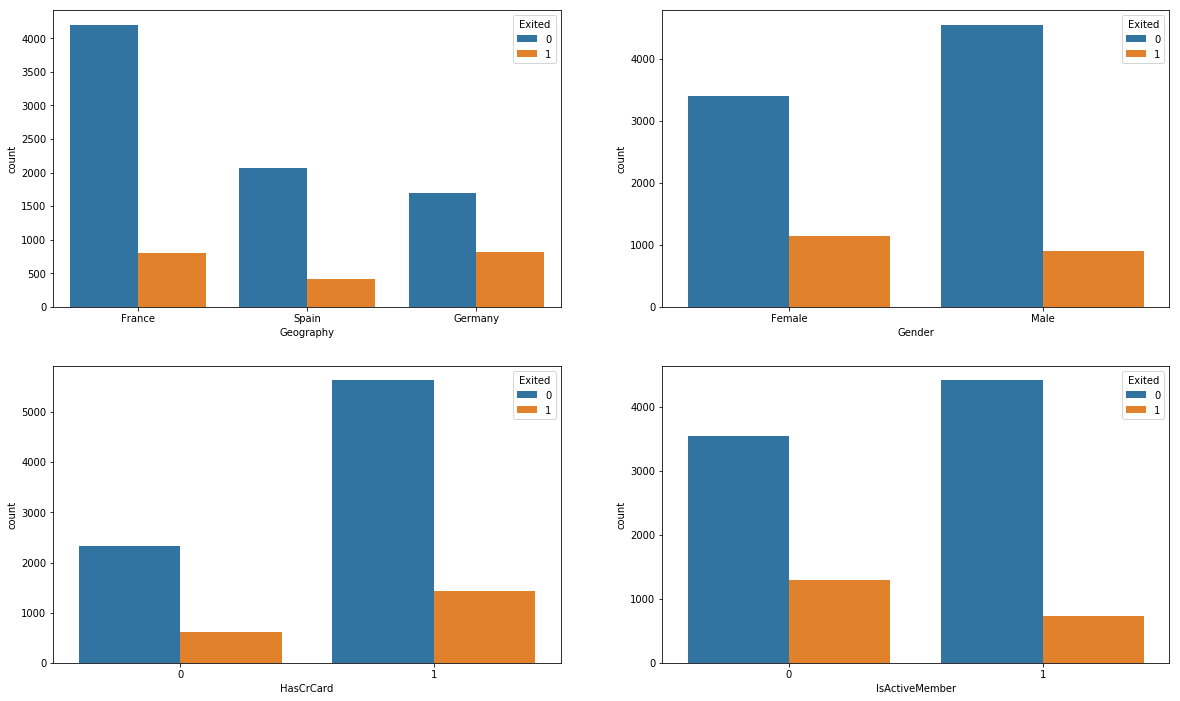

In [18]:
    # We first review the 'Status' relation with categorical variables
    fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
    sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
    sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
    sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
    sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])

We note the following:
* Majority of the data is from persons from France. However, the proportion of churned customers is with inversely related to the population of customers alluding to the bank possibly having a problem (maybe not enough customer service resources allocated) in the areas where it has fewer clients.
* The proportion of female customers churning is also greater than that of male customers
* Interestingly, majority of the customers that churned are those with credit cards. Given that majority of the customers have credit cards could prove this to be just a coincidence. 
* Unsurprisingly the inactive members have a greater churn. Worryingly is that the overall proportion of inactive mebers is quite high suggesting that the bank may need a program implemented to turn this group to active customers as this will definately have a positive impact on the customer churn.


C:\Users\ab275\Anaconda3\lib\site-packages\seaborn\categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


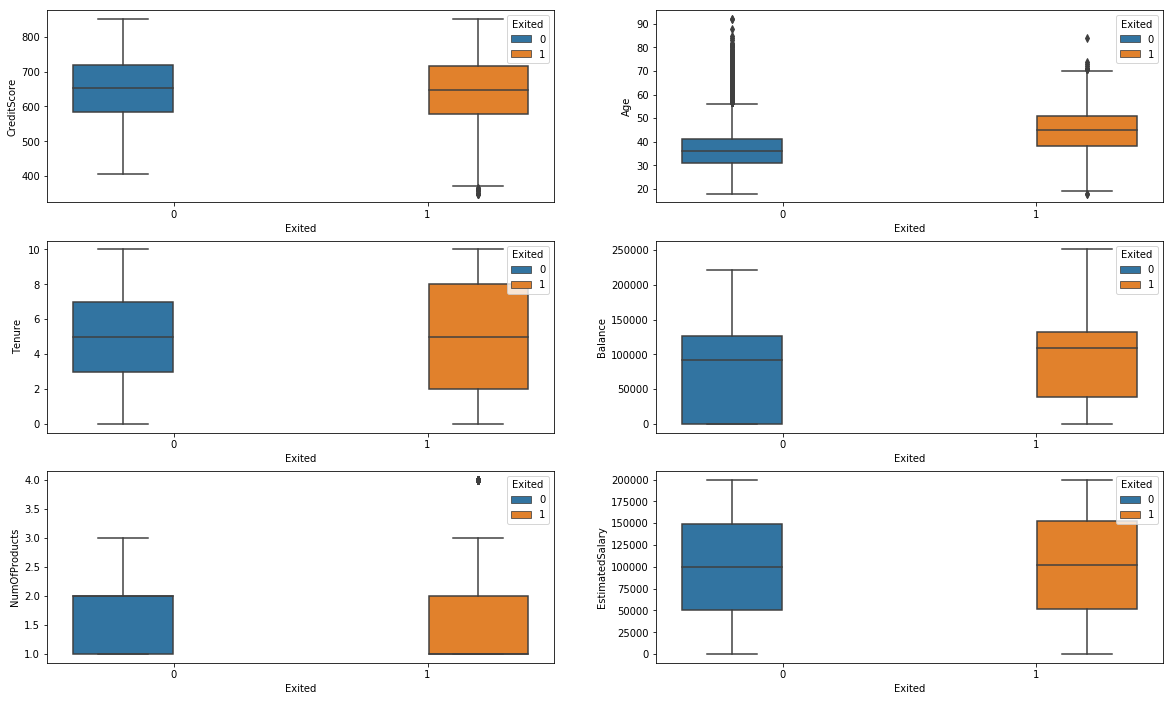

In [19]:
    # Relations based on the continuous data attributes
    fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
    sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = df, ax=axarr[0][0])
    sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = df , ax=axarr[0][1])
    sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][0])
    sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][1])
    sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][0])
    sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][1])

We note the following:
* There is no significant difference in the credit score distribution between retained and churned customers. 
* The older customers are churning at more than the younger ones alluding to a difference in service preference in the age categories. The bank may need to review their target market or review the strategy for retention between the different age groups
* With regard to the tenure, the clients on either extreme end (spent little time with the bank or a lot of time with the bank) are more likely to churn compared to those that are of average tenure.
*  Worryingly, the bank is losing customers with significant bank balances which is likely to hit their available capital for lending.
* Neither the product nor the salary has a significant effect on the likelihood to churn.

## 4. Feature engineering
We seek to add features that are likely to have an impact on the probability of churning.

C:\Users\ab275\Anaconda3\lib\site-packages\seaborn\categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


(-1, 5)

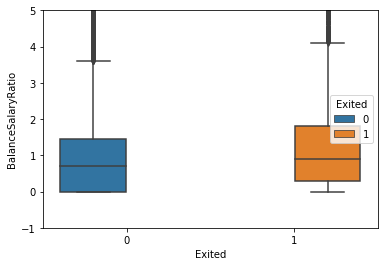

In [10]:
df['BalanceSalaryRatio'] = df.Balance/df.EstimatedSalary
sns.boxplot(y='BalanceSalaryRatio',x = 'Exited', hue = 'Exited',data = df)
plt.ylim(-1, 5)

we have seen that the salary has little effect on the chance of a customer churning. However as seen above, the ratio of the bank balance and the estimated salary indicates that customers with a higher balance salary ratio churn more which would be worrying to the bank as this impacts their source of loan capital.

C:\Users\ab275\Anaconda3\lib\site-packages\seaborn\categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


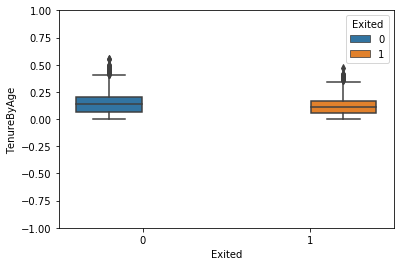

In [9]:
# Given that tenure is a 'function' of age, we introduce a variable aiming to standardize tenure over age:
df['TenureByAge'] = df.Tenure/(df.Age)
sns.boxplot(y='TenureByAge',x = 'Exited', hue = 'Exited',data = df)
plt.ylim(-1, 1)
plt.show()

In [11]:
'''Lastly we introduce a variable to capture credit score given age to take into account credit behaviour visavis adult life
:-)'''
df['CreditScoreGivenAge'] = df.CreditScore/(df.Age)

In [12]:
# Resulting Data Frame
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,TenureByAge,BalanceSalaryRatio,CreditScoreGivenAge
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.047619,0.000000,14.738095
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.024390,0.744677,14.829268
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,0.190476,1.401375,11.952381
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.025641,0.000000,17.923077
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0.046512,1.587055,19.767442


## 5. Data prep for model fitting

In [13]:
# Arrange columns by data type for easier manipulation
continuous_vars = ['CreditScore',  'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary', 'BalanceSalaryRatio',
                   'TenureByAge','CreditScoreGivenAge']
cat_vars = ['HasCrCard', 'IsActiveMember','Geography', 'Gender']
df = df[['Exited'] + continuous_vars + cat_vars]
df.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography,Gender
0,1,619,42,2,0.00,1,101348.88,0.000000,0.047619,14.738095,1,1,France,Female
1,0,608,41,1,83807.86,1,112542.58,0.744677,0.024390,14.829268,0,1,Spain,Female
2,1,502,42,8,159660.80,3,113931.57,1.401375,0.190476,11.952381,1,0,France,Female
3,0,699,39,1,0.00,2,93826.63,0.000000,0.025641,17.923077,0,0,France,Female
4,0,850,43,2,125510.82,1,79084.10,1.587055,0.046512,19.767442,1,1,Spain,Female


In [14]:
'''For the one hot variables, we change 0 to -1 so that the models can capture a negative relation 
where the attribute in inapplicable instead of 0'''
df.loc[df.HasCrCard == 0, 'HasCrCard'] = -1
df.loc[df.IsActiveMember == 0, 'IsActiveMember'] = -1
df.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography,Gender
0,1,619,42,2,0.00,1,101348.88,0.000000,0.047619,14.738095,1,1,France,Female
1,0,608,41,1,83807.86,1,112542.58,0.744677,0.024390,14.829268,-1,1,Spain,Female
2,1,502,42,8,159660.80,3,113931.57,1.401375,0.190476,11.952381,1,-1,France,Female
3,0,699,39,1,0.00,2,93826.63,0.000000,0.025641,17.923077,-1,-1,France,Female
4,0,850,43,2,125510.82,1,79084.10,1.587055,0.046512,19.767442,1,1,Spain,Female


In [15]:
# One hot encode the categorical variables
lst = ['Geography', 'Gender']
remove = list()
for i in lst:
    if (df[i].dtype == np.str or df[i].dtype == np.object):
        for j in df[i].unique():
            df[i+'_'+j] = np.where(df[i] == j,1,-1)
        remove.append(i)
df = df.drop(remove, axis=1)
df.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography_France,Geography_Spain,Geography_Germany,Gender_Female,Gender_Male
0,1,619,42,2,0.00,1,101348.88,0.000000,0.047619,14.738095,1,1,1,-1,-1,1,-1
1,0,608,41,1,83807.86,1,112542.58,0.744677,0.024390,14.829268,-1,1,-1,1,-1,1,-1
2,1,502,42,8,159660.80,3,113931.57,1.401375,0.190476,11.952381,1,-1,1,-1,-1,1,-1
3,0,699,39,1,0.00,2,93826.63,0.000000,0.025641,17.923077,-1,-1,1,-1,-1,1,-1
4,0,850,43,2,125510.82,1,79084.10,1.587055,0.046512,19.767442,1,1,-1,1,-1,1,-1


In [16]:
# minMax scaling the continuous variables
minVec = df[continuous_vars].min().copy()
maxVec = df[continuous_vars].max().copy()
df[continuous_vars] = (df[continuous_vars]-minVec)/(maxVec-minVec)
df.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography_France,Geography_Spain,Geography_Germany,Gender_Female,Gender_Male
0,1,0.538,0.324324,0.2,0.000000,0.000000,0.506735,0.000000,0.085714,0.235083,1,1,1,-1,-1,1,-1
1,0,0.516,0.310811,0.1,0.334031,0.000000,0.562709,0.000070,0.043902,0.237252,-1,1,-1,1,-1,1,-1
2,1,0.304,0.324324,0.8,0.636357,0.666667,0.569654,0.000132,0.342857,0.168807,1,-1,1,-1,-1,1,-1
3,0,0.698,0.283784,0.1,0.000000,0.333333,0.469120,0.000000,0.046154,0.310859,-1,-1,1,-1,-1,1,-1
4,0,1.000,0.337838,0.2,0.500246,0.000000,0.395400,0.000150,0.083721,0.354739,1,1,-1,1,-1,1,-1


## 6. Model fitting and selection
For the model fitting, I will try out the following
* Decision Tree
* Random Forest

## Decision Tree Algorithm
A decision tree is a flowchart-like tree structure where an internal node represents feature(or attribute), the branch represents a decision rule, and each leaf node represents the outcome. The topmost node in a decision tree is known as the root node. It learns to partition on the basis of the attribute value. It partitions the tree in recursively manner call recursive partitioning. This flowchart-like structure helps you in decision making. It's visualization like a flowchart diagram which easily mimics the human level thinking. That is why decision trees are easy to understand and interpret.

<img src = 'decisiontree1.png'>

## How does the Decision Tree algorithm work?
The basic idea behind any decision tree algorithm is as follows:

Select the best attribute using Attribute Selection Measures(ASM) to split the records.
Make that attribute a decision node and breaks the dataset into smaller subsets.
Starts tree building by repeating this process recursively for each child until one of the condition will match:
All the tuples belong to the same attribute value.
There are no more remaining attributes.
There are no more instances.
Most popular attribute selection measures are Information Gain, and Gini Index.

<img src = "decisiontree2.png">
<img src = "decisiontree3.png">



In [17]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [18]:
X = df.drop('Exited',axis=1) # Features
y = df.Exited # Target variable
print(X.shape)
print(y.shape)

(10000, 16)
(10000,)


In [19]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) # 70% training and 30% test

In [41]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth=1)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [42]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.792


Well, we got a classification rate of 79.2%, considered as good accuracy. We can improve this accuracy by tuning the parameters in the Decision Tree Algorithm

## Visualizing the Decision Tree

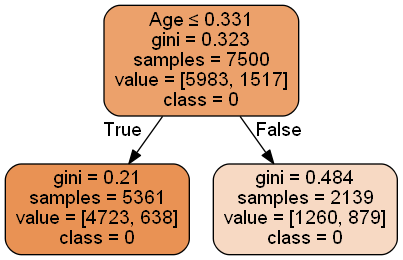

In [32]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X.columns.tolist(),class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('decision_tree.png')
Image(graph.create_png())

## Optimization of Decision Tree

In [33]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8404


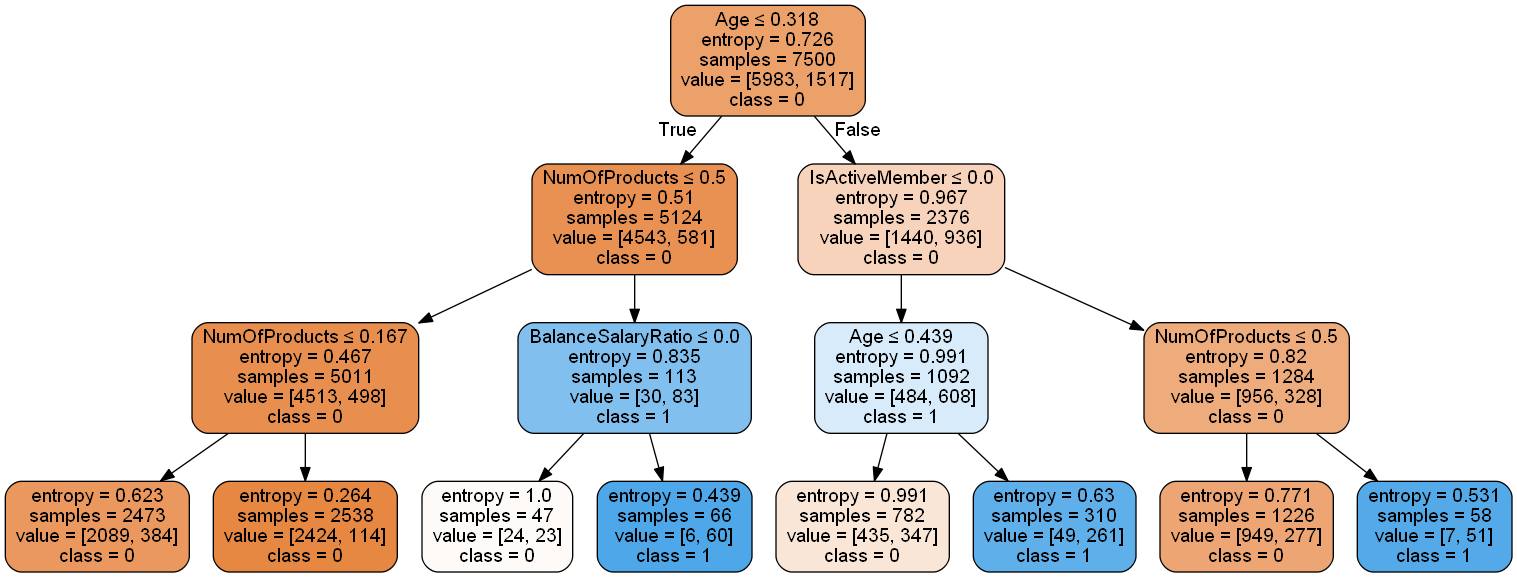

In [34]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X.columns.tolist(),class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('decision_tree.png')
Image(graph.create_png())

# Random Forest
Random forests is a supervised learning algorithm. It can be used both for classification and regression. It is also the most flexible and easy to use algorithm. A forest is comprised of trees. It is said that the more trees it has, the more robust a forest is. Random forests creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. It also provides a pretty good indicator of the feature importance.

It technically is an ensemble method (based on the divide-and-conquer approach) of decision trees generated on a randomly split dataset. This collection of decision tree classifiers is also known as the forest. The individual decision trees are generated using an attribute selection indicator such as information gain, gain ratio, and Gini index for each attribute. Each tree depends on an independent random sample. In a classification problem, each tree votes and the most popular class is chosen as the final result. In the case of regression, the average of all the tree outputs is considered as the final result. It is simpler and more powerful compared to the other non-linear classification algorithms.


## How does the algorithm work?
It works in four steps:

* Select random samples from a given dataset.
* Construct a decision tree for each sample and get a prediction result from each decision tree.
* Perform a vote for each predicted result.
* Select the prediction result with the most votes as the final prediction.

## Random Forests vs Decision Trees
Random forests is a set of multiple decision trees.
Deep decision trees may suffer from overfitting, but random forests prevents overfitting by creating trees on random subsets.
Decision trees are computationally faster.
Random forests is difficult to interpret, while a decision tree is easily interpretable and can be converted to rules.

In [64]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
rf_clf=RandomForestClassifier(n_estimators=100,random_state=1)

#Train the model using the training sets
rf_clf.fit(X_train,y_train)

y_pred=rf_clf.predict(X_test)

In [65]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8648


In [50]:
feature_imp = pd.Series(rf_clf.feature_importances_,index=X.columns.tolist()).sort_values(ascending=False)
feature_imp

Age                    0.153048
CreditScoreGivenAge    0.131357
NumOfProducts          0.118046
CreditScore            0.095436
EstimatedSalary        0.091435
Balance                0.091406
TenureByAge            0.078153
BalanceSalaryRatio     0.073446
Tenure                 0.046157
IsActiveMember         0.043277
Geography_Germany      0.019381
HasCrCard              0.014886
Gender_Female          0.011775
Gender_Male            0.011413
Geography_France       0.010523
Geography_Spain        0.010261
dtype: float64

C:\Users\ab275\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
No handles with labels found to put in legend.


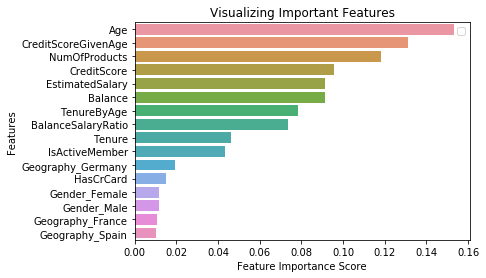

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## Generating the Model on Important Features

Select top 12 features only

In [68]:
X=df[feature_imp.index[:11]]
y=df['Exited']                                       
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) # 75% training and 25% test

In [69]:
rf_clf=RandomForestClassifier(n_estimators=100,random_state=1)

#Train the model using the training sets
rf_clf.fit(X_train,y_train)

# prediction on test set
y_pred=rf_clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8652
